# Quick Start with AAanalysis
**AAanalysis** is a Python framework for sequence-based protein prediction, centered around the ``CPP`` model for interpretable feature engineering.

First import some third-party packages and ``aanalsis``:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import aaanalysis as aa
aa.options["verbose"] = False

We can load a dataset of amino acid scales and an example dataset for γ-secretase of 50 substrates and 50 non-substrates:

In [2]:
df_scales = aa.load_scales()
df_seq = aa.load_dataset(name="DOM_GSEC", n=50)

Starting the **Feature Engineering**, we first utilize the  ``AAclust`` model for pre-selecting a redundancy-reduced set of amino acid scales:

In [3]:
aac = aa.AAclust()
X = np.array(df_scales).T
scales = aac.fit(X, names=list(df_scales), n_clusters=100).medoid_names_ 
df_scales = df_scales[scales]

We can now use the *Comparative Physical Profiling (CPP)* algorithm, which aims at identifying a set of features most discriminant between two sets of sequences. Its core idea is the CPP feature concept, defined as a combination of *Parts*, *Splits*, and *Scales*. Parts and Splits can be obtained using ``SequenceFeature``:

In [4]:
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd_jmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])

Running the CPP algorithm creates all Part, Split, Split combinations and filters a selected maximum of non-redundant features. As a baseline approach,
we use CPP to compute the average values for the 100 selected scales over the entire TMD-JMD sequences:

In [5]:
# Small set of CPP features (100 features are created)
y = list(df_seq["label"])
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, split_kws=split_kws)
df_feat = cpp.run(labels=y) 

For **Machine Learning**, a feature matrix from a given set of CPP features can be created using ``sf.feat_matrix``:

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = sf.feat_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, y, scoring="accuracy")
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.63


Creating more features with CPP will take a little time, but improve prediction performance: 

Mean accuracy of 0.88


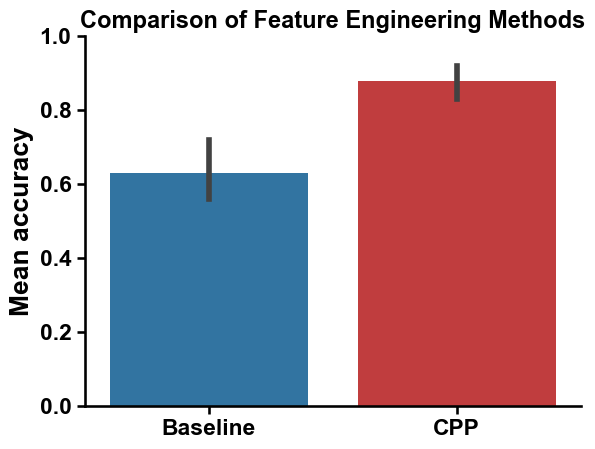

In [7]:
# CPP features with default splits (around 100.000 features)
df_parts = sf.get_df_parts(df_seq=df_seq)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts)
df_feat = cpp.run(labels=y)
X = sf.feat_matrix(df_parts=df_parts, features=df_feat["feature"])

rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=1) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")

aa.plot_settings()
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
plt.ylim(0, 1)
plt.title("Comparison of Feature Engineering Methods", size=aa.plot_gcfs()-1)
sns.despine()
plt.show()